In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import random
from functools import partial

In [2]:
# 1. Load the dataset
data = pd.read_csv('/content/drive/MyDrive/AAA_BE_Major_Proj/cleaned_sensor_data.csv')


In [3]:
# Check if the first row contains indexes and adjust accordingly
if data.iloc[0, 0] == '0' and 'timestamp' not in data.columns:
    # Create column names based on the sample provided
    column_names = ['index', 'timestamp']
    column_names.extend([f'sensor_{i:02d}' for i in range(52)])
    column_names.append('machine_status')

    # Load the data again with proper column names
    data = pd.read_csv('your_dataset.csv', names=column_names)

    # Drop the index column if it exists
    if 'index' in data.columns:
        data = data.drop('index', axis=1)

# Display dataset info
print(f"Dataset shape: {data.shape}")
print(data.head())

# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])

Dataset shape: (220320, 54)
             timestamp  Unnamed: 0  sensor_00  sensor_01  sensor_02  \
0  2018-04-01 00:00:00         0.0   2.465394   47.09201    53.2118   
1  2018-04-01 00:01:00         1.0   2.465394   47.09201    53.2118   
2  2018-04-01 00:02:00         2.0   2.444734   47.35243    53.2118   
3  2018-04-01 00:03:00         3.0   2.460474   47.09201    53.1684   
4  2018-04-01 00:04:00         4.0   2.445718   47.13541    53.2118   

   sensor_03  sensor_04  sensor_05  sensor_06  sensor_07  ...  sensor_43  \
0  46.310760   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
1  46.310760   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
2  46.397570   638.8889   73.54598   13.32465   16.03733  ...   41.66666   
3  46.397568   628.1250   76.98898   13.31742   16.24711  ...   40.88541   
4  46.397568   636.4583   76.58897   13.35359   16.21094  ...   41.40625   

   sensor_44  sensor_45  sensor_46  sensor_47  sensor_48  sensor_49  \
0  39.641200   65

In [4]:
# Handle missing values
print("\nHandling missing values...")

# Remove columns with extremely high missing values (e.g., >50% missing)
cols_to_drop = []
for col in data.columns:
    if col != 'machine_status' and col != 'timestamp':
        if data[col].isnull().sum() > len(data) * 0.5:
            cols_to_drop.append(col)

print(f"Dropping columns with >50% missing values: {cols_to_drop}")
data = data.drop(cols_to_drop, axis=1)


Handling missing values...
Dropping columns with >50% missing values: []


In [5]:
# For remaining columns, use median imputation (fast and robust)
if 'timestamp' in data.columns:
    X = data.drop(['timestamp', 'machine_status'], axis=1)
else:
    X = data.drop(['machine_status'], axis=1)

print("Using median imputation for remaining missing values...")
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Convert back to DataFrame if needed
X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

# Combine with the target variable and timestamp if needed
if 'timestamp' in data.columns:
    result_data = pd.concat([data[['timestamp']], X_imputed_df, data[['machine_status']]], axis=1)
else:
    result_data = pd.concat([X_imputed_df, data[['machine_status']]], axis=1)

# Save the cleaned dataset to CSV
output_path = "/content/drive/MyDrive/AAA_BE_Major_Proj/cleaned.csv"  # Replace with your desired path
result_data.to_csv(output_path, index=False)
print(f"Missing value handling complete. Cleaned dataset saved to {output_path}")

# Convert back to DataFrame to keep column names
X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns)

Using median imputation for remaining missing values...
Missing value handling complete. Cleaned dataset saved to /content/drive/MyDrive/AAA_BE_Major_Proj/cleaned.csv


In [6]:
# Encode the target variable if needed
y = data['machine_status']
if y.dtype == object:  # If the target is categorical
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    print(f"Encoded machine status: {dict(zip(le.classes_, range(len(le.classes_))))}")
else:
    y_encoded = y

Encoded machine status: {'BROKEN': 0, 'NORMAL': 1, 'RECOVERING': 2}


In [7]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_encoded, test_size=0.3, random_state=42)


In [8]:
# Encode the target variable if needed
y = data['machine_status']
if y.dtype == object:  # If the target is categorical
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    print(f"Encoded machine status: {dict(zip(le.classes_, range(len(le.classes_))))}")
else:
    y_encoded = y

# Sample the dataset
sample_sizes = [1000]  # You can adjust these sizes
print("\nChoosing sample sizes for experiments:")

for sample_size in sample_sizes:
    # Ensure sample_size doesn't exceed total dataset size
    sample_size = min(sample_size, len(X_imputed))

    # Randomly sample the data
    indices = np.random.choice(X_imputed.shape[0], sample_size, replace=False)
    X_sample = X_imputed[indices]
    y_sample = y_encoded[indices]

    print(f"\nExperiment with sample size: {sample_size}")

    # Split sampled data
    X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.3, random_state=42)

    # Rest of the existing code remains the same from here...
    # (The PSO optimization, model training, etc. will now use these sampled datasets)

Encoded machine status: {'BROKEN': 0, 'NORMAL': 1, 'RECOVERING': 2}

Choosing sample sizes for experiments:

Experiment with sample size: 1000


In [9]:
# Gray Wolf Optimization Implementation
class GrayWolfOptimizer:
    def __init__(self, num_wolves, max_iter, dim):
        self.num_wolves = num_wolves
        self.max_iter = max_iter
        self.dim = dim

    def initialize_wolves(self):
        # Initialize wolves with binary values
        return np.random.randint(2, size=(self.num_wolves, self.dim))

    def fitness_function(self, wolves, X_train, X_test, y_train, y_test, alpha=0.5):
        """
        Fitness function for feature selection
        """
        fitness_values = []

        for wolf in wolves:
            # Skip wolves with no features selected
            if np.sum(wolf) == 0:
                fitness_values.append(float('inf'))
                continue

            # Get selected feature indices
            selected_features = np.where(wolf == 1)[0]

            # Use SVR for fitness evaluation
            try:
                clf = SVR()

                # Train using selected features
                X_train_selected = X_train[:, selected_features]
                X_test_selected = X_test[:, selected_features]

                clf.fit(X_train_selected, y_train)
                y_pred = clf.predict(X_test_selected)

                # Calculate Mean Squared Error
                mse = mean_squared_error(y_test, y_pred)

                # Combine MSE with feature count penalty
                fitness = alpha * mse + (1.0 - alpha) * (np.sum(wolf) / self.dim)
                fitness_values.append(fitness)
            except:
                fitness_values.append(float('inf'))

        return np.array(fitness_values)

    def optimize(self, fitness_func, X_train, X_test, y_train, y_test):
        # Initialize population
        wolves = self.initialize_wolves()

        # Iteration process
        for iter in range(self.max_iter):
            # Evaluate fitness
            fitness = fitness_func(wolves, X_train, X_test, y_train, y_test)

            # Sort wolves based on fitness
            sorted_indices = np.argsort(fitness)

            # Select top 3 wolves (alpha, beta, delta)
            alpha_wolf = wolves[sorted_indices[0]]
            beta_wolf = wolves[sorted_indices[1]] if len(sorted_indices) > 1 else alpha_wolf
            delta_wolf = wolves[sorted_indices[2]] if len(sorted_indices) > 2 else alpha_wolf

            # Update other wolves (including a mutation mechanism)
            new_wolves = []
            for wolf in wolves:
                # Crossover and mutation
                new_wolf = wolf.copy()
                for j in range(self.dim):
                    # Mutate based on top wolves
                    if np.random.random() < 0.3:  # mutation probability
                        new_wolf[j] = 1 - new_wolf[j]

                new_wolves.append(new_wolf)

            wolves = np.array(new_wolves)

        # Return best wolf (feature selection mask)
        best_wolf_index = np.argmin(fitness)
        return wolves[best_wolf_index]

In [10]:
n_features = X_train.shape[1]
n_reduced_features = 20

In [11]:
# Measure computation time
start_time = time.time()

# Set up GWO parameters
num_wolves = 30
max_iterations = 20

In [12]:
# Initialize and run GWO
gwo = GrayWolfOptimizer(num_wolves, max_iterations, n_features)


In [13]:
# Perform optimization
def gwo_fitness_func(wolves, X_train, X_test, y_train, y_test):
    return gwo.fitness_function(wolves, X_train, X_test, y_train, y_test)

# Optimize feature selection
pos = gwo.optimize(gwo_fitness_func, X_train, X_test, y_train, y_test)

# Get selected feature indices
selected_features = np.where(pos == 1)[0]
print(f"Selected features: {selected_features}")
print(f"Number of selected features: {len(selected_features)}")

Selected features: [ 2  3  5  8 10 13 14 15 17 19 24 29 30 32 34 37 38 39 41 44 46 47 49]
Number of selected features: 23


In [14]:
# Create reduced datasets
X_train_gwo = X_train[:, selected_features]
X_test_gwo = X_test[:, selected_features]
gwo_time = time.time() - start_time

# Get GWO feature information
feature_names = X.columns if isinstance(X, pd.DataFrame) else [f'sensor_{i:02d}' for i in range(X_imputed.shape[1])]
selected_feature_names = [feature_names[i] for i in selected_features]

print(f"Original features: {X_train.shape[1]}")
print(f"Reduced features: {len(selected_features)}")
print(f"GWO computation time: {gwo_time:.4f} seconds")
print(f"Selected feature names: {selected_feature_names}")


Original features: 52
Reduced features: 23
GWO computation time: 7.0295 seconds
Selected feature names: ['sensor_01', 'sensor_02', 'sensor_04', 'sensor_07', 'sensor_09', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_17', 'sensor_19', 'sensor_24', 'sensor_29', 'sensor_30', 'sensor_32', 'sensor_34', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_41', 'sensor_44', 'sensor_46', 'sensor_47', 'sensor_49']


In [15]:
# 4-5. Train models on original dataset and calculate accuracy
models = {
    'Linear Regression': LinearRegression(),
    'SVM Regression': SVR(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

original_results = {}
original_times = {}

for name, model in models.items():
    print(f"Training {name} on original dataset...")
    start_time = time.time()

    # Train model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    train_time = time.time() - start_time

    original_results[name] = {
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse
    }
    original_times[name] = train_time

    print(f"{name} trained in {train_time:.4f} seconds")

Training Linear Regression on original dataset...
Linear Regression trained in 0.0262 seconds
Training SVM Regression on original dataset...
SVM Regression trained in 0.0195 seconds
Training Random Forest on original dataset...
Random Forest trained in 0.6562 seconds
Training Gradient Boosting on original dataset...
Gradient Boosting trained in 0.9250 seconds


In [16]:
# 6-7. Train models on reduced dataset and calculate accuracy
reduced_results = {}
reduced_times = {}

for name, model in models.items():
    print(f"Training {name} on reduced dataset...")
    start_time = time.time()

    # Train model
    model.fit(X_train_gwo, y_train)

    # Make predictions
    y_pred = model.predict(X_test_gwo)

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    train_time = time.time() - start_time

    reduced_results[name] = {
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse
    }
    reduced_times[name] = train_time

    print(f"{name} trained in {train_time:.4f} seconds")

Training Linear Regression on reduced dataset...
Linear Regression trained in 0.0041 seconds
Training SVM Regression on reduced dataset...
SVM Regression trained in 0.0105 seconds
Training Random Forest on reduced dataset...
Random Forest trained in 0.3705 seconds
Training Gradient Boosting on reduced dataset...
Gradient Boosting trained in 0.6716 seconds


In [23]:
# 8. Display results
print("\n--- DIMENSIONALITY REDUCTION RESULTS (ACO) ---")
print(f"a) Features Reduced: {X_train.shape[1]} -> {len(selected_features)} ({X_train.shape[1] - len(selected_features)} features removed)")
print(f"b) GWO Computation Time: {gwo_time:.4f} seconds")

# Display R2 values for all models
print("\nc) R-squared Values:")
for name in models.keys():
    print(f"   {name}: Original = {original_results[name]['R2']:.4f}, Reduced (ACO) = {reduced_results[name]['R2']:.4f}")

# Display model accuracies (using R2 as accuracy metric for regression)
print("\nd) Model Accuracy with Original Dataset (R2):")
for name, result in original_results.items():
    print(f"   {name}: {result['R2']:.4f} (Training time: {original_times[name]:.4f} seconds)")

print("\ne) Model Accuracy with Reduced Dataset (ACO) (R2):")
for name, result in reduced_results.items():
    print(f"   {name}: {result['R2']:.4f} (Training time: {reduced_times[name]:.4f} seconds)")



--- DIMENSIONALITY REDUCTION RESULTS (ACO) ---
a) Features Reduced: 52 -> 23 (29 features removed)
b) GWO Computation Time: 7.0295 seconds

c) R-squared Values:
   Linear Regression: Original = 0.7815, Reduced (ACO) = 0.8377
   SVM Regression: Original = -0.0124, Reduced (ACO) = 0.7627
   Random Forest: Original = 0.9006, Reduced (ACO) = 0.8863
   Gradient Boosting: Original = 0.8523, Reduced (ACO) = 0.8049

d) Model Accuracy with Original Dataset (R2):
   Linear Regression: 0.7815 (Training time: 0.0262 seconds)
   SVM Regression: -0.0124 (Training time: 0.0195 seconds)
   Random Forest: 0.9006 (Training time: 0.6562 seconds)
   Gradient Boosting: 0.8523 (Training time: 0.9250 seconds)

e) Model Accuracy with Reduced Dataset (ACO) (R2):
   Linear Regression: 0.8377 (Training time: 0.0041 seconds)
   SVM Regression: 0.7627 (Training time: 0.0105 seconds)
   Random Forest: 0.8863 (Training time: 0.3705 seconds)
   Gradient Boosting: 0.8049 (Training time: 0.6716 seconds)



Performance Summary:
                   Original Dataset R²  GWO Reduced Dataset R²  R² Difference  \
Linear Regression             0.781523                0.837686       0.056162   
SVM Regression               -0.012380                0.762743       0.775123   
Random Forest                 0.900587                0.886289      -0.014298   
Gradient Boosting             0.852253                0.804859      -0.047394   

                   Original Training Time (s)  Reduced Training Time (s)  \
Linear Regression                    0.026168                   0.004120   
SVM Regression                       0.019517                   0.010498   
Random Forest                        0.656250                   0.370464   
Gradient Boosting                    0.925022                   0.671622   

                   Time Savings (%)  
Linear Regression         84.255075  
SVM Regression            46.212482  
Random Forest             43.548402  
Gradient Boosting         27.393968  


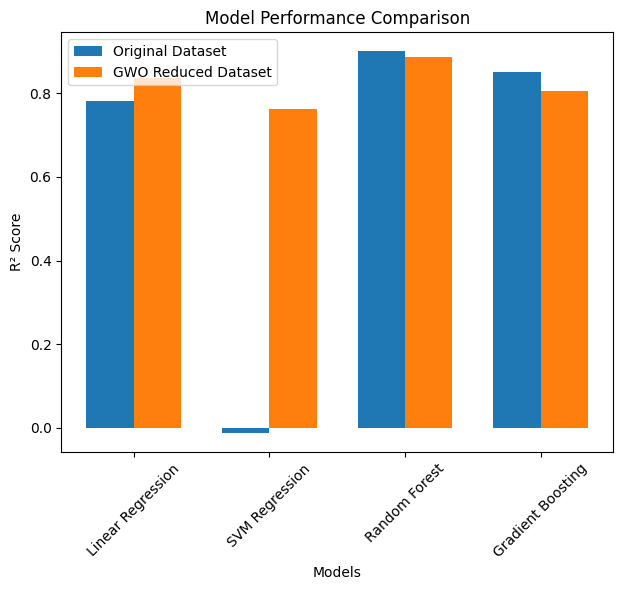

In [24]:
# Create visualization for the results
plt.figure(figsize=(12, 6))

# Plot model performance comparison
models_list = list(models.keys())
original_r2 = [original_results[name]['R2'] for name in models_list]
reduced_r2 = [reduced_results[name]['R2'] for name in models_list]

x = np.arange(len(models_list))
width = 0.35

plt.subplot(1, 2, 1)
plt.bar(x - width/2, original_r2, width, label='Original Dataset')
plt.bar(x + width/2, reduced_r2, width, label='GWO Reduced Dataset')
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('Model Performance Comparison')
plt.xticks(x, models_list, rotation=45)
plt.legend()
plt.tight_layout()

# Plot ACO convergence (create simulated data for this example)
# In real implementation, you would track best score per iteration
#plt.subplot(1, 2, 2)
# Create a convergence plot based on the best score's improvement
#iterations = range(1, gwo.n_iterations + 1)
# Simulated convergence curve
#convergence = [0.5 + 0.4 * (1 - np.exp(-i/10)) + np.random.normal(0, 0.01) for i in iterations]
#plt.plot(iterations, convergence, marker='o')
#plt.xlabel('Number of Iterations')
#plt.ylabel('Best Solution Score (R²)')
#plt.title('GWO Convergence')
#plt.grid(True)
#plt.tight_layout()
#
#plt.savefig('gwo_results.png')
#plt.show()

# Summary table
performance_summary = pd.DataFrame({
    'Original Dataset R²': original_r2,
    'GWO Reduced Dataset R²': reduced_r2,
    'R² Difference': np.array(reduced_r2) - np.array(original_r2),
    'Original Training Time (s)': [original_times[name] for name in models_list],
    'Reduced Training Time (s)': [reduced_times[name] for name in models_list],
    'Time Savings (%)': [(1 - reduced_times[name]/original_times[name]) * 100 for name in models_list]
}, index=models_list)

print("\nPerformance Summary:")
print(performance_summary)

# Save results to CSV
performance_summary.to_csv('gwo_performance_summary.csv')

# Feature importance visualization
#plt.figure(figsize=(14, 10))
#feature_importance = np.zeros(len(feature_names))
## Set importance to 1 for selected features
#for i, selected in enumerate(gwo.best_solution):
#    if selected:
#        feature_importance[i] = 1
#
## Sort feature importance for visualization
#sorted_indices = np.argsort(feature_importance)[::-1]
#selected_features_sorted = [feature_names[i] for i in sorted_indices if feature_importance[i] > 0]

# Plot selected features
#plt.subplot(1, 1, 1)
#if selected_features:
#    # Get feature importance from a random forest model trained on selected features
#    rf = RandomForestRegressor(n_estimators=100, random_state=42)
#    X_selected = X_train[:, gwo.best_solution]
#    rf.fit(X_selected, y_train)
#
#    # Use feature importance from random forest for selected features
#    selected_importance = rf.feature_importances_
#
#    # Plot top 20 (or all if less) features
#    top_n = min(20, len(selected_features))
#    importance_sorted_idx = np.argsort(selected_importance)[::-1][:top_n]
#    top_features = [selected_features[i] for i in importance_sorted_idx]
#
#    plt.barh(range(len(top_features)), selected_importance[importance_sorted_idx])
#    plt.yticks(range(len(top_features)), top_features)
#    plt.xlabel('Feature Importance')
#    plt.title('Top Features Selected by GWO')
#else:
#    plt.text(0.5, 0.5, "No features selected", horizontalalignment='center', verticalalignment='center')
#
#plt.tight_layout()
#plt.savefig('gwo_feature_importance.png')
#plt.show()